In [1]:
# Import libraries
import numpy as np #type:ignore
import pandas as pd #type:ignore
import janitor #type:ignore
import zipfile
import json
import pandasql as ps #type:ignore

# Visualization
import matplotlib.pyplot as plt #type:ignore
import seaborn as sns #type:ignore
from plotly.express import choropleth, choropleth_mapbox #type:ignore
import missingno as msno #type:ignore
from utils import missing, strings

# Processing
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler) #type:ignore

In [2]:
# !kaggle datasets download -d  thedevastator/unlock-profits-with-e-commerce-sales-data

# with zipfile.ZipFile("unlock-profits-with-e-commerce-sales-data.zip", "r") as zippy:
#     zippy.extractall("../data/ecommerce_data")

In [3]:
dt = pd.read_csv("../data/Amazon Sale Report.csv", header=0, sep=",", low_memory=False)
data = dt.copy()
data.tail(2).T

,128973,128974
index,128973,128974
Order ID,402-6184140-0545956,408-7436540-8728312
Date,05-31-22,05-31-22
Status,Shipped,Shipped
Fulfilment,Amazon,Amazon
Sales Channel,Amazon.in,Amazon.in
ship-service-level,Expedited,Expedited
Style,J0012,J0003
SKU,J0012-SKD-XS,J0003-SET-S
Category,Set,Set


In [4]:
data = data.clean_names(
    case_type="snake"
)

In [5]:
data.columns

Index(['index', 'order_id', 'date', 'status', 'fulfilment', 'sales_channel_',
       'ship_service_level', 'style', 'sku', 'category', 'size', 'asin',
       'courier_status', 'qty', 'currency', 'amount', 'ship_city',
       'ship_state', 'ship_postal_code', 'ship_country', 'promotion_ids',
       'b2_b', 'fulfilled_by', 'unnamed_22'],
      dtype='object')

In [6]:
data.shape

(128975, 24)

`Amazon Sale Report` indicates complete data related to shipping of diverse articles distributed in _India_, we have information related to zones courier service. 

Hence, we could classify behavior trends according to regions, amount of money spent in certain time span likewise in cities, and target B2B or B2C bool customers.

In [7]:
data.dtypes

index                   int64
order_id               object
date                   object
status                 object
fulfilment             object
sales_channel_         object
ship_service_level     object
style                  object
sku                    object
category               object
size                   object
asin                   object
courier_status         object
qty                     int64
currency               object
amount                float64
ship_city              object
ship_state             object
ship_postal_code      float64
ship_country           object
promotion_ids          object
b2_b                     bool
fulfilled_by           object
unnamed_22             object
dtype: object

In [8]:
data.select_dtypes(include=['int', 'bool', 'float'])

,index,qty,amount,ship_postal_code,b2_b
0,0,0,647.62,400081.0,False
1,1,1,406.00,560085.0,False
2,2,1,329.00,410210.0,True
3,3,0,753.33,605008.0,False
4,4,1,574.00,600073.0,False
...,...,...,...,...,...
128970,128970,1,517.00,500013.0,False
128971,128971,1,999.00,122004.0,False
128972,128972,1,690.00,500049.0,False
128973,128973,1,1199.00,389350.0,False


In [9]:
(
    data.isna()
    .sum()
    .reset_index()
    .rename(
        columns={
            "index" : "feature",
            0 : "missing_values"
        }
    )
    .sort_values(by="missing_values", ascending=False)
    .iloc[:10, :]
    .assign(
            pct_missing = lambda df: round((df.missing_values / data.shape[0])*100, 2)
    )
)

,feature,missing_values,pct_missing
22,fulfilled_by,89698,69.55
20,promotion_ids,49153,38.11
23,unnamed_22,49050,38.03
14,currency,7795,6.04
15,amount,7795,6.04
12,courier_status,6872,5.33
19,ship_country,33,0.03
16,ship_city,33,0.03
17,ship_state,33,0.03
18,ship_postal_code,33,0.03


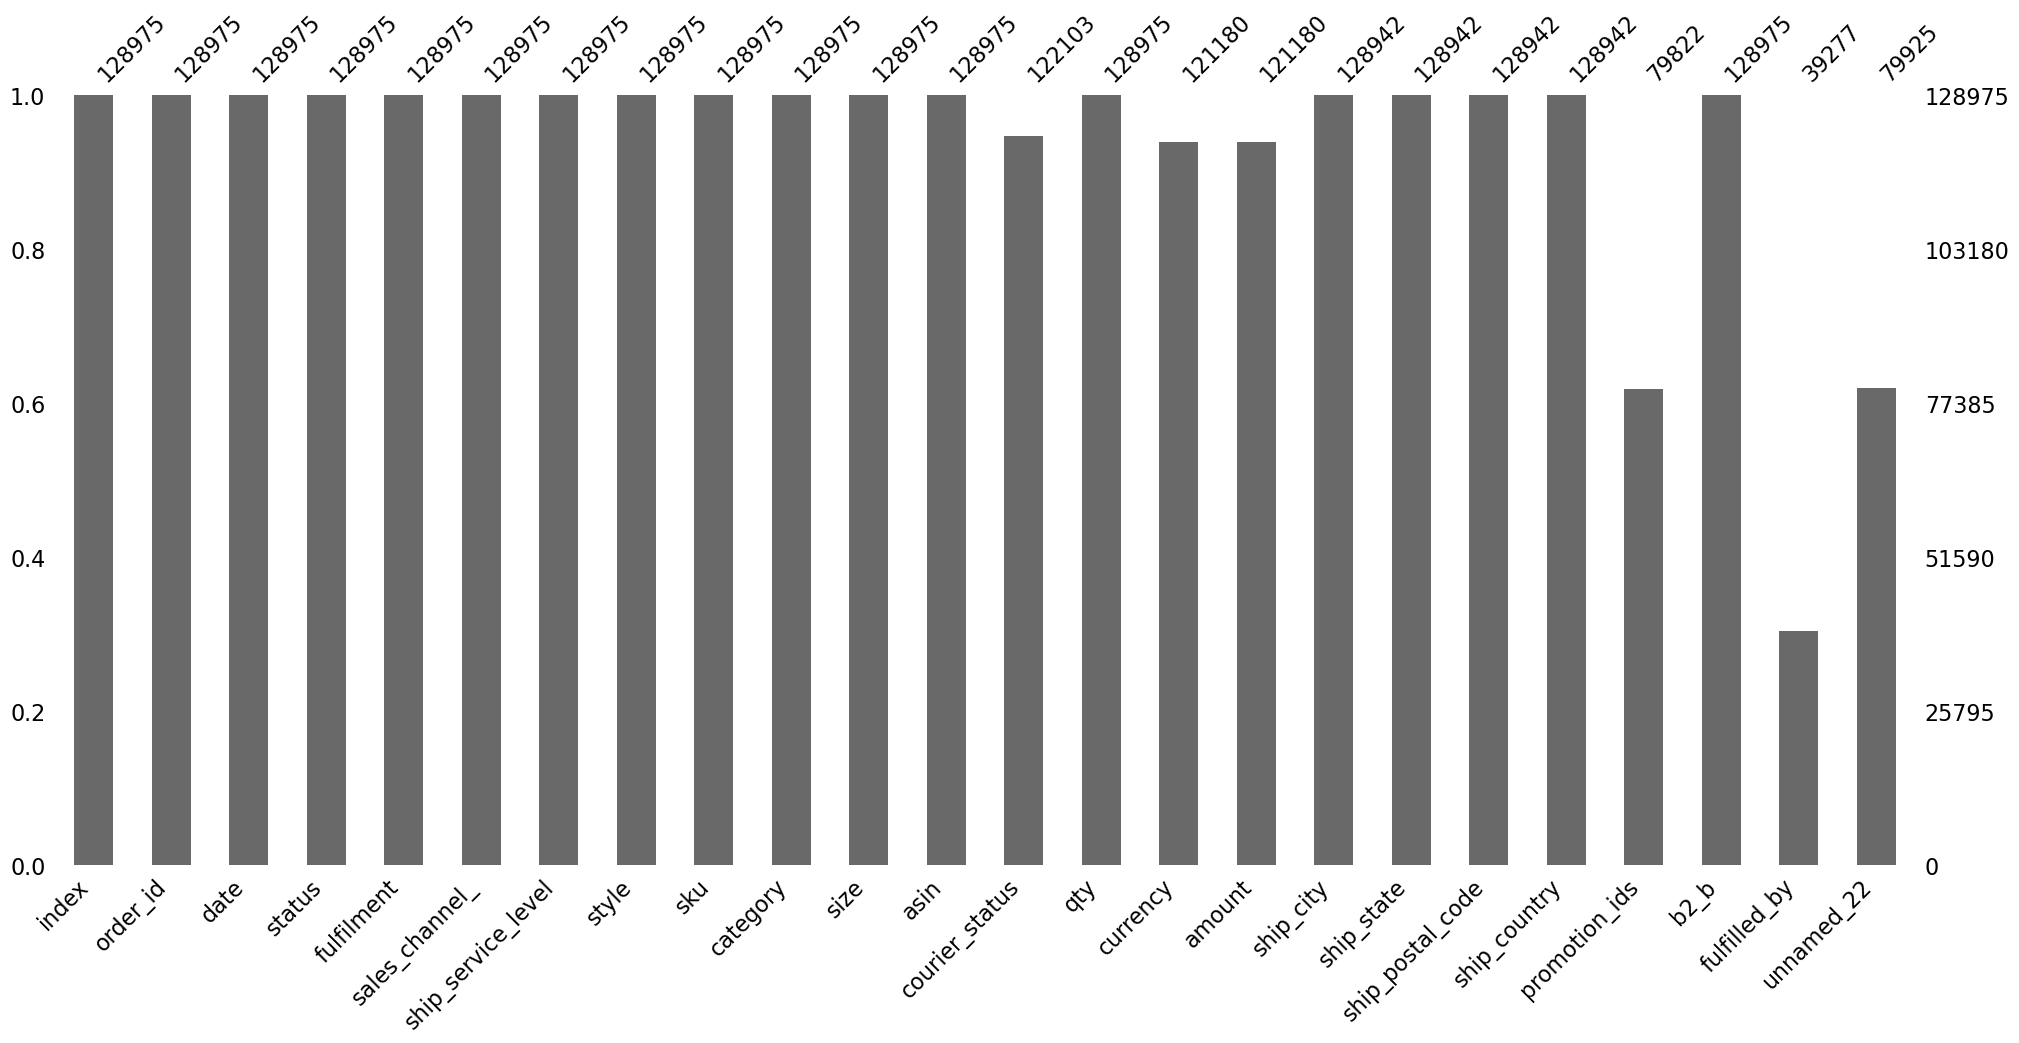

In [10]:
msno.bar(data)
plt.show()

In [11]:
data.unnamed_22.unique()

array([nan, False], dtype=object)

The column `unnamed_22` does not provide any value to our analysis, it could be removed from `data`.

In [12]:
data.drop(labels="unnamed_22", axis=1, inplace=True)

We need to impute missing values prior to continue with analysis of this dataset.

/home/fenilenvinileno97/miniconda3/envs/missing_values/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Strings were found, treat them


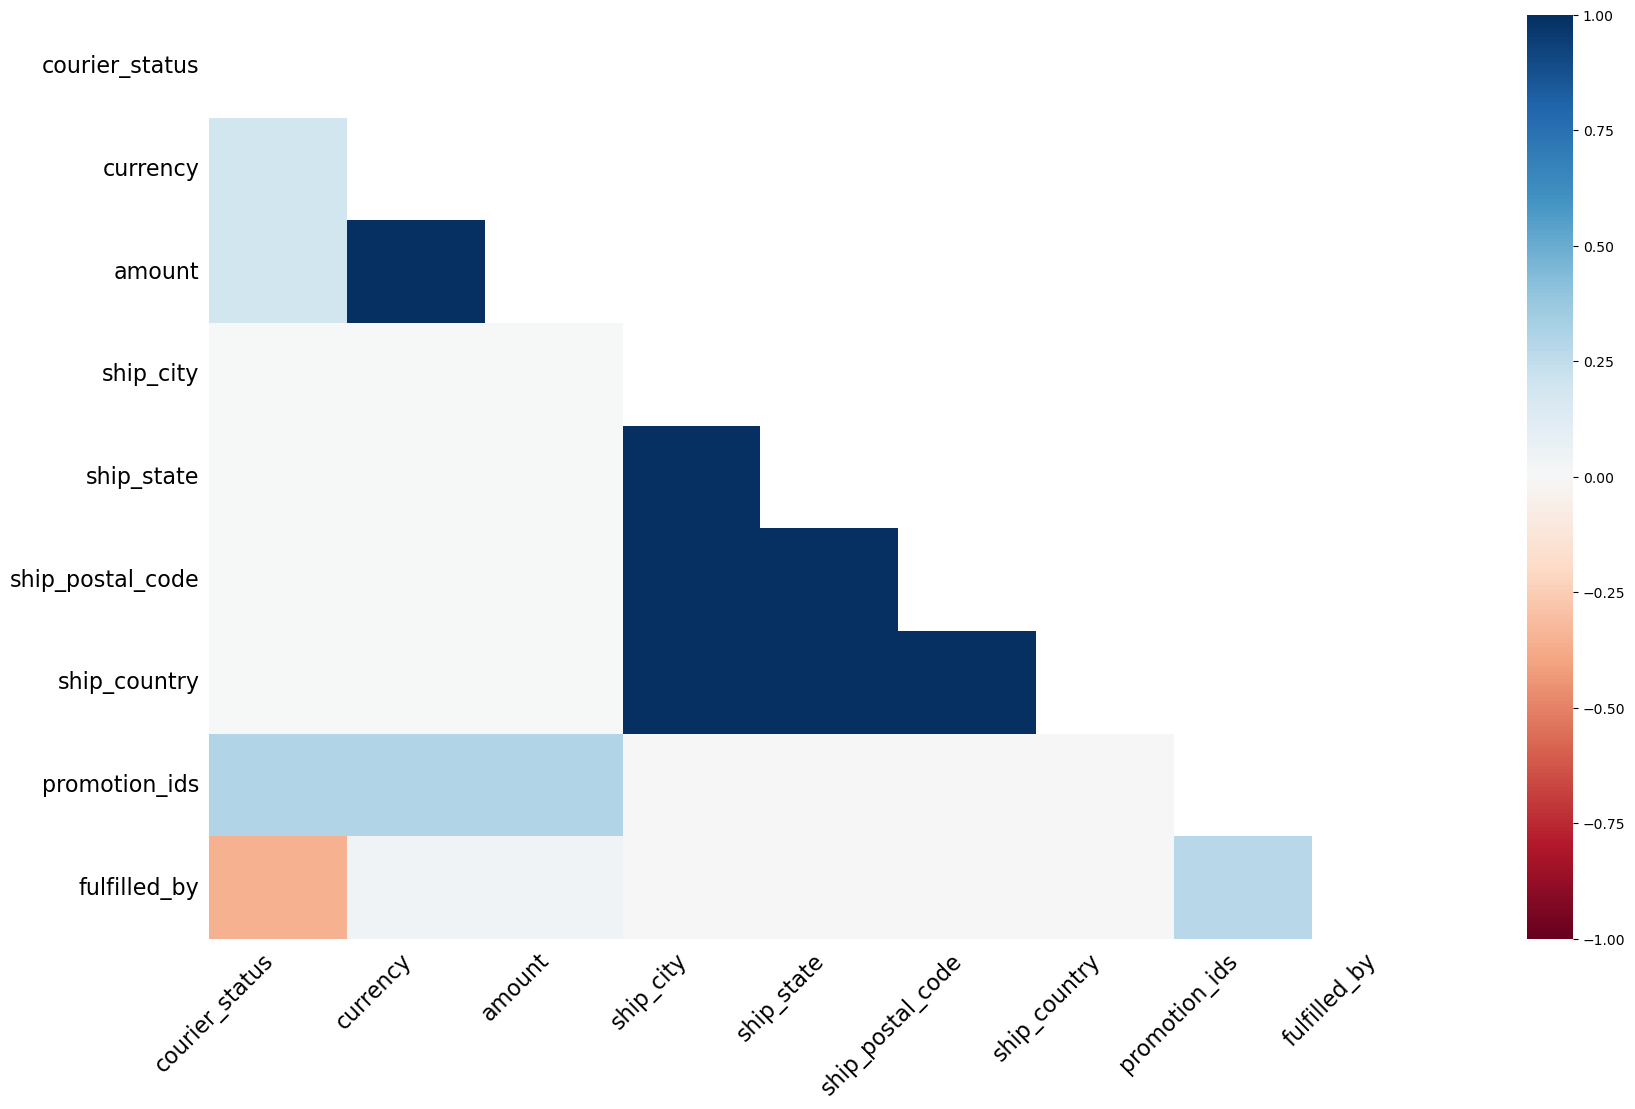

In [13]:
try:
    msno.heatmap(
        df=data
    );
    plt.show();
except ValueError:
    print("Strings were found, treat them")

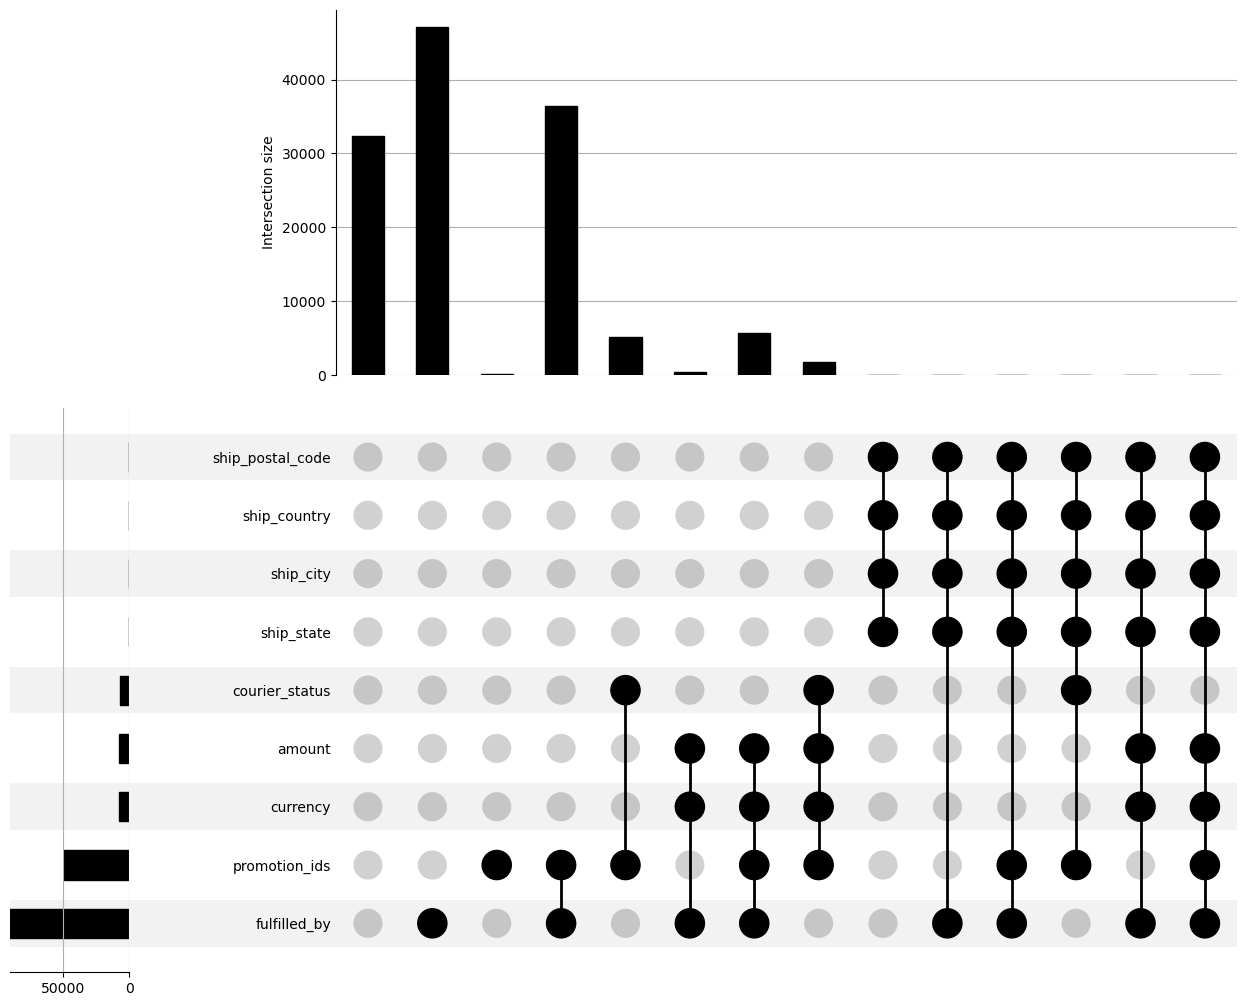

In [14]:
data_na = data[data.columns[data.isna().any()]]
data_na.missing.missing_upsetplot(
    variables=None,
    element_size=60
    )
plt.show()

In [15]:
data.fulfilled_by.unique()

array(['Easy Ship', nan], dtype=object)

`fulfilled_by` is a feature related to the type of shipping, in this case, a merchant or distributor who previously purchased from Amazon, has a warehouse where products are allocated and then distributed in an efficient manner. 

_Easy Ship_ means that Amazon manages the shipping logistics but the seller is still responsible for storing the product at their own location. Other categories are unknown from this dataset, hence, missing values will be replaced by including _Other category_.

In [16]:
data.fulfilled_by.fillna(
    value="Other category",
    inplace=True
)

In the other hand, `promotion_ids` is not relevant to our analysis, it is an `ID` type, so we could not extract important insights from it.

In [17]:
data.promotion_ids.unique()

array([nan,
       'Amazon PLCC Free-Financing Universal Merchant AAT-WNKTBO3K27EJC,Amazon PLCC Free-Financing Universal Merchant AAT-QX3UCCJESKPA2,Amazon PLCC Free-Financing Universal Merchant AAT-5QQ7BIYYQEDN2,Amazon PLCC Free-Financing Universal Merchant AAT-DSJ2QRXXWXVMQ,Amazon PLCC Free-Financing Universal Merchant AAT-CXJHMC2YJUK76,Amazon PLCC Free-Financing Universal Merchant AAT-CC4FAVTYR4X7C,Amazon PLCC Free-Financing Universal Merchant AAT-XXRCW6NZEPZI4,Amazon PLCC Free-Financing Universal Merchant AAT-CXNSLNBROFDW4,Amazon PLCC Free-Financing Universal Merchant AAT-R7GXNZWISTRFA,Amazon PLCC Free-Financing Universal Merchant AAT-WSJLDN3X7KEMO,Amazon PLCC Free-Financing Universal Merchant AAT-VL6FGQVGQVXUS,Amazon PLCC Free-Financing Universal Merchant AAT-EOKPWFWYW7Y6I,Amazon PLCC Free-Financing Universal Merchant AAT-ZYL5UPUNW6T62,Amazon PLCC Free-Financing Universal Merchant AAT-XVPICCHRWDCAI,Amazon PLCC Free-Financing Universal Merchant AAT-ETXQ3XXWMRXBG,Amazon PLCC Free-Fin

In [18]:
data.drop(columns="promotion_ids", axis=1, inplace=True)

In [19]:
data.ship_country.unique()

array(['IN', nan], dtype=object)

In [20]:
data.ship_country.fillna(value="IN", inplace=True)

`currency` is highly probably to be _INR_, since, sales are carried out only in India. In addition, _INR_ is the only one value besides _NaN_.

In [21]:
data.currency.fillna(value="INR", inplace=True)

`courier_status` has three categories: _Shipped_, _Unshipped_, and _Cancelled_, no other category is logical in courier. Nevertheless, we could place another one as _Lost_, which makes reference for that case where courier has no response and we can not determine its status. Hence, missing value will be set as _Lost_:

In [22]:
data.courier_status.value_counts()

Shipped      109487
Unshipped      6681
Cancelled      5935
Name: courier_status, dtype: int64

In [23]:
data.courier_status.fillna(value="Lost", inplace=True)

Similarly, it is difficult to determine whether `ship_state` is different to any of Indian states. So, it could be helpful, replacing missing values with _Other region_, which makes reference to another possible zone in India. 

In addition, it could be helpful to determine if exist repeated values within.

In [24]:
data.ship_state.unique()

array(['MAHARASHTRA', 'KARNATAKA', 'PUDUCHERRY', 'TAMIL NADU',
       'UTTAR PRADESH', 'CHANDIGARH', 'TELANGANA', 'ANDHRA PRADESH',
       'RAJASTHAN', 'DELHI', 'HARYANA', 'ASSAM', 'JHARKHAND',
       'CHHATTISGARH', 'ODISHA', 'KERALA', 'MADHYA PRADESH',
       'WEST BENGAL', 'NAGALAND', 'Gujarat', 'UTTARAKHAND', 'BIHAR',
       'JAMMU & KASHMIR', 'PUNJAB', 'HIMACHAL PRADESH',
       'ARUNACHAL PRADESH', 'MANIPUR', 'Goa', 'MEGHALAYA', 'GOA',
       'TRIPURA', 'LADAKH', 'DADRA AND NAGAR', 'SIKKIM', 'Delhi', nan,
       'ANDAMAN & NICOBAR ', 'Punjab', 'Rajshthan', 'Manipur',
       'rajasthan', 'Odisha', 'NL', 'Bihar', 'MIZORAM', 'punjab',
       'New Delhi', 'Rajasthan', 'Punjab/Mohali/Zirakpur', 'Puducherry',
       'delhi', 'RJ', 'Chandigarh', 'orissa', 'LAKSHADWEEP', 'goa', 'PB',
       'APO', 'Arunachal Pradesh', 'AR', 'Pondicherry', 'Sikkim',
       'Arunachal pradesh', 'Nagaland', 'bihar', 'Mizoram', 'rajsthan',
       'Orissa', 'Rajsthan', 'Meghalaya'], dtype=object)

In [25]:
data.ship_state.fillna(value="Other region", inplace=True)

As we could observe, in `ship_state`, there are repeated values as _PUNJAB_ with _punjab_, or _delhi_ with _New Delhi_, besides, there are abbreviations which do not provide a useful form to process or analyze data. By using Wikipedia available 28 indian states names, we proceed to clean this data, respecting the _Other region_ category that replaced missing values.

In [26]:
with open("../data/indian_states.json", "r") as indian:
    states = json.load(indian)

In [27]:
# Data lists
states_json = []
states_id = []

# Iterating over states geojson.
for indian_state in range(len(states["features"])):
    states_json.append(states["features"][indian_state]["properties"]["NAME_1"])
    states_id.append(states["features"][indian_state]["properties"]["ID_1"])
    
state_mapping = {key:value for key, value in zip(states_json, states_id)}

In [28]:
# Applying cap_format to ship_state column.
data["ship_state"] = (
    data["ship_state"]
    .apply(
        lambda df: strings.String(df).cap_format()
    )
)

# Unmatching values.
unmatching = list(set(data.ship_state.unique()) - set(states_json))

# Replacing unmatching values with possible coincidences in our dataset.
replace_unmatching = [
    "Punjab", "Rajasthan", "Nagaland", "Andhra Pradesh", "Dadra and Nagar Haveli", "Jammu and Kashmir", "Rajasthan", "Puducherry", "Arunachal Pradesh", "Telangana", "Uttarakhand", "Delhi", "Other Region", "Ladakh", "Punjab", "Rajasthan", "Andaman and Nicobar", "Orissa"
]

# Replacement dictionary.
replaces = {key:value for key, value in zip(unmatching, replace_unmatching)}

In [29]:
# Replacing and cleaning of ship_state.
data["ship_state"].replace(replaces, inplace=True)

Preparing data for choropleth map of India:

In [37]:
# Matching the states that have geojson data.
geodata_available = set(data["ship_state"].unique()) & set(states_json)

# Creating a working dataframe for choropleth.
indian_state_values = data[data["ship_state"].isin(geodata_available)].loc[:, ["ship_state", "amount"]]

# Indicating id new column for this.
indian_state_values["id"] = indian_state_values["ship_state"].map(state_mapping)
indian_state_values = indian_state_values[["id", "ship_state", "amount"]]

indian_state_values.tail()

,id,ship_state,amount
128970,1,Andaman and Nicobar,517.0
128971,13,Haryana,999.0
128972,1,Andaman and Nicobar,690.0
128973,12,Gujarat,1199.0
128974,7,Chhattisgarh,696.0


In [71]:
for i in range(len(states["features"])):
    search = states["features"][i]["properties"]["NAME_1"]
    print(search, type(search))

Andaman and Nicobar <class 'str'>
Andhra Pradesh <class 'str'>
Arunachal Pradesh <class 'str'>
Assam <class 'str'>
Bihar <class 'str'>
Chandigarh <class 'str'>
Chhattisgarh <class 'str'>
Dadra and Nagar Haveli <class 'str'>
Daman and Diu <class 'str'>
Delhi <class 'str'>
Goa <class 'str'>
Gujarat <class 'str'>
Haryana <class 'str'>
Himachal Pradesh <class 'str'>
Jammu and Kashmir <class 'str'>
Jharkhand <class 'str'>
Karnataka <class 'str'>
Kerala <class 'str'>
Lakshadweep <class 'str'>
Madhya Pradesh <class 'str'>
Maharashtra <class 'str'>
Manipur <class 'str'>
Meghalaya <class 'str'>
Mizoram <class 'str'>
Nagaland <class 'str'>
Orissa <class 'str'>
Puducherry <class 'str'>
Punjab <class 'str'>
Rajasthan <class 'str'>
Sikkim <class 'str'>
Tamil Nadu <class 'str'>
Tripura <class 'str'>
Uttar Pradesh <class 'str'>
Uttaranchal <class 'str'>
West Bengal <class 'str'>


In [52]:
# fig = choropleth(
#     data_frame=indian_state_values,
#     locations='id',
#     geojson=states,
#     color='amount',
#     hover_name='ship_state',
#     hover_data=['amount'],
#     # scope='asia',
#     labels={"amount" : "USD"}
# )

# # Update the layout to fit the map
# fig.update_geos(
#     center={"lat": 20.5937, "lon": 78.9629},  # Center on India
#     projection_type="mercator",    # Use Mercator projection
#     fitbounds="locations"          # Automatically fit bounds to the locations
# )

# # Show the plot
# fig.show()

Same approach is applied in `ship_city`:

In [104]:
data.ship_city.value_counts()

BENGALURU                                             11217
HYDERABAD                                              8074
MUMBAI                                                 6126
NEW DELHI                                              5795
CHENNAI                                                5421
                                                      ...  
Harwada, Ankola                                           1
Titwala ( East)                                           1
PATNApatna                                                1
Sbi Fagu                                                  1
Goppenahalli, Channagiri Taluk, Davangere district        1
Name: ship_city, Length: 8955, dtype: int64

In [105]:
data.ship_city.fillna(value="Other city", inplace=True)

`ship_postal_code` is intimately related with `ship_city`, so probably we could find matches with replaced missing values already known as _Other city_, with a null value in postal code.

In [106]:
data[data.ship_postal_code.isna()][["ship_city", "ship_postal_code"]]

,ship_city,ship_postal_code
1871,Other city,NaN
1872,Other city,NaN
8752,Other city,NaN
11215,Other city,NaN
13252,Other city,NaN
15688,Other city,NaN
16787,Other city,NaN
18351,Other city,NaN
22930,Other city,NaN
24986,Other city,NaN


As we proved our hypothesis, it is possible to replace null values with an arbitary code of six zeros, **000000**:

In [107]:
data.ship_postal_code.fillna(value=000000, inplace=True)

# Write about amount analysis!

In [108]:
bfill_amount = data.amount.fillna(method="bfill", inplace=False).reset_index()

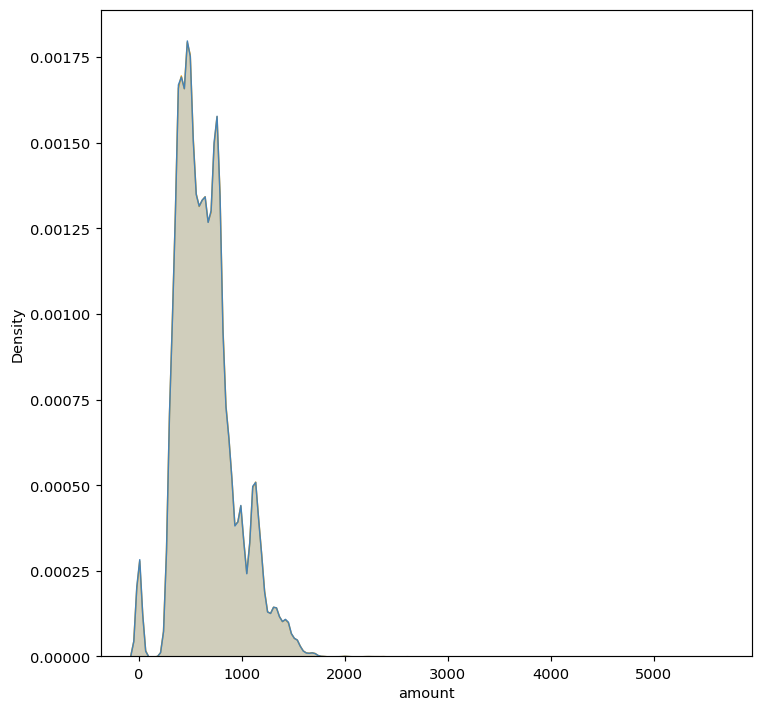

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=105)
sns.kdeplot(data=data, x="amount", fill=True, color="orange", ax=ax)
sns.kdeplot(data=bfill_amount, x="amount", fill=True, color="steelblue", ax=ax) # Filled values by backward filling.
plt.show()

In [110]:
data.amount.fillna(method="bfill", inplace=True)

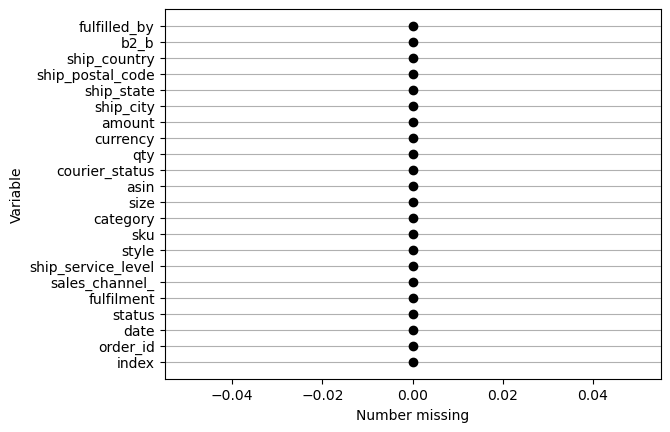

In [111]:
data.missing.missing_variable_plot()

### Cleaning data

After treating missing values, we may remove some features that could cause overfitting, introduce inaccuracies, or increase training time. Based on our criteria, some features do not provide any predictive or classification capability due to their intrinsic values. In such case, they are just merely identifiers as `ID` serial or primary keys.

#### Categorical product identifiers

In [112]:
identifiers_categorical_labels = data[["index", "sku", "style", "asin"]]
identifiers_categorical_labels

,index,sku,style,asin
0,0,SET389-KR-NP-S,SET389,B09KXVBD7Z
1,1,JNE3781-KR-XXXL,JNE3781,B09K3WFS32
2,2,JNE3371-KR-XL,JNE3371,B07WV4JV4D
3,3,J0341-DR-L,J0341,B099NRCT7B
4,4,JNE3671-TU-XXXL,JNE3671,B098714BZP
...,...,...,...,...
128970,128970,JNE3697-KR-XL,JNE3697,B098112V2V
128971,128971,SET401-KR-NP-M,SET401,B09VC6KHX8
128972,128972,J0157-DR-XXL,J0157,B0982YZ51B
128973,128973,J0012-SKD-XS,J0012,B0894Y2NJQ


In [113]:
ids_labels_size = {label : value.unique().shape[0] for label, value in identifiers_categorical_labels.items()}
ids_labels_size

{'index': 128975, 'sku': 7195, 'style': 1377, 'asin': 7190}

Removing those identifiers categorical values.

In [114]:
data.drop(
    columns=["index", "sku", "style", "asin"],
    inplace=True
    )

In [115]:
filter_bool_dtypes = {feature : data[feature].unique().shape[0] for feature in data.columns}
bool_dtypes = {key : value for key, value in filter_bool_dtypes.items() if value ==2}
bool_dtypes

{'fulfilment': 2,
 'sales_channel_': 2,
 'ship_service_level': 2,
 'b2_b': 2,
 'fulfilled_by': 2}

In [116]:
data[list(bool_dtypes.keys())]

,fulfilment,sales_channel_,ship_service_level,b2_b,fulfilled_by
0,Merchant,Amazon.in,Standard,False,Easy Ship
1,Merchant,Amazon.in,Standard,False,Easy Ship
2,Amazon,Amazon.in,Expedited,True,Other category
3,Merchant,Amazon.in,Standard,False,Easy Ship
4,Amazon,Amazon.in,Expedited,False,Other category
...,...,...,...,...,...
128970,Amazon,Amazon.in,Expedited,False,Other category
128971,Amazon,Amazon.in,Expedited,False,Other category
128972,Amazon,Amazon.in,Expedited,False,Other category
128973,Amazon,Amazon.in,Expedited,False,Other category


In [117]:
list(bool_dtypes.keys())

['fulfilment', 'sales_channel_', 'ship_service_level', 'b2_b', 'fulfilled_by']

In [118]:
# Processing bool data
encoder = OneHotEncoder(
        sparse_output=False, 
        drop='first',
        handle_unknown='error',
        categories='auto'  
    )

In [119]:
encoded_data = encoder.fit_transform(data[list(bool_dtypes.keys())])
print(encoder.feature_names_in_)

['fulfilment' 'sales_channel_' 'ship_service_level' 'b2_b' 'fulfilled_by']


In [120]:
feature_names = encoder.get_feature_names_out(encoder.feature_names_in_)

In [121]:
encoded_data = pd.DataFrame(
    encoded_data, 
    columns=feature_names
    )

encoded_data.columns = encoder.feature_names_in_

In [122]:
data[encoder.feature_names_in_.tolist()] = encoded_data

Converting string dtype from `date` is converted to `datetime` format.

In [123]:
data["date"] = pd.to_datetime(data.date)

--------------------------------------------------------------------------

### Features related to mailing order

In [124]:
order_features = ["order_id", "status", "fulfilment", "sales_channel_"]
data[order_features]

,order_id,status,fulfilment,sales_channel_
0,405-8078784-5731545,Cancelled,1.0,0.0
1,171-9198151-1101146,Shipped - Delivered to Buyer,1.0,0.0
2,404-0687676-7273146,Shipped,0.0,0.0
3,403-9615377-8133951,Cancelled,1.0,0.0
4,407-1069790-7240320,Shipped,0.0,0.0
...,...,...,...,...
128970,406-6001380-7673107,Shipped,0.0,0.0
128971,402-9551604-7544318,Shipped,0.0,0.0
128972,407-9547469-3152358,Shipped,0.0,0.0
128973,402-6184140-0545956,Shipped,0.0,0.0


`Order ID` is a variable which makes reference to an unique value type since it matches a particular sent order, is not so valuable for meaning of predicting of classifying, just to track and identify an object from this database.

In case of `sales_channel_` and `fulfilment`, both were assigned to direct `Amazon` service and merchants Amazon resellers.

In [125]:
shipped_query = "SELECT * FROM data WHERE status LIKE '%Shipped%'"
shipped = ps.sqldf(shipped_query, locals())

In [126]:
(
    shipped.status
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "index" : "status",
            "status" : "appearances"
        }
    )
    .assign(
        percentage = lambda df: round((df.appearances * 100 / df.appearances.sum(numeric_only=True)), 2)
    )
)


,status,appearances,percentage
0,Shipped,77804,70.93
1,Shipped - Delivered to Buyer,28769,26.23
2,Shipped - Returned to Seller,1953,1.78
3,Shipped - Picked Up,973,0.89
4,Shipped - Returning to Seller,145,0.13
5,Shipped - Out for Delivery,35,0.03
6,Shipped - Rejected by Buyer,11,0.01
7,Shipped - Lost in Transit,5,0.00
8,Shipped - Damaged,1,0.00


Returns compound a small percentage of total shippings, circa 2% of total. Very few shipped orders were cancelled due to rejections or losses.

In [127]:
not_shipped_query = "SELECT * FROM data WHERE status NOT LIKE '%Shipped%'"
not_shipped = ps.sqldf(not_shipped_query, locals())

(
    not_shipped.status
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "index" : "status",
            "status" : "appearances"
        }
    )
    .assign(
        percentage = lambda df: round((df.appearances * 100 / df.appearances.sum(numeric_only=True)), 2)
    )
)

,status,appearances,percentage
0,Cancelled,18332,95.09
1,Pending,658,3.41
2,Pending - Waiting for Pick Up,281,1.46
3,Shipping,8,0.04


In the stage previous to a confirmed shipping, mostly of orders were cancelled. User is a 95.1% likely to cancel in this case, this trend is normal when user exhibits an undecided behavior. Albeit, this could be a feature to be analyzed along with UX interaction at moment of purchasing. 

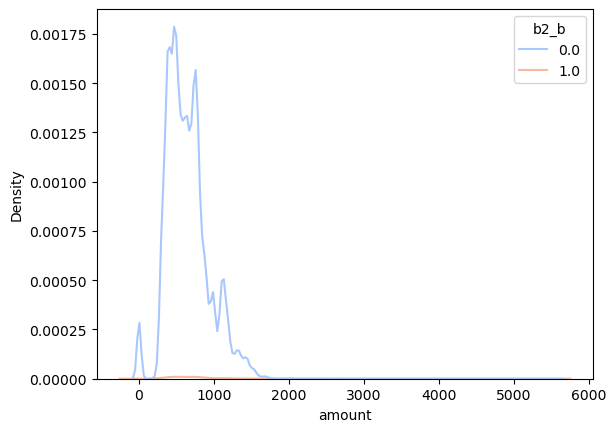

In [128]:
sns.kdeplot(data=data, x="amount", hue="b2_b", palette="coolwarm")
plt.show()

### Features related to clothes characteristics.

In [129]:
clothes_cat_features = data[["size", "category", "b2_b"]]
clothes_cat_features

,size,category,b2_b
0,S,Set,0.0
1,3XL,kurta,0.0
2,XL,kurta,1.0
3,L,Western Dress,0.0
4,3XL,Top,0.0
...,...,...,...
128970,XL,kurta,0.0
128971,M,Set,0.0
128972,XXL,Western Dress,0.0
128973,XS,Set,0.0


In [130]:
clothes_cat_dict = {feature : clothes_cat_features[feature].unique().shape[0] for feature in clothes_cat_features.columns}
clothes_cat_dict

{'size': 11, 'category': 9, 'b2_b': 2}

In [131]:
ord_encoder = OrdinalEncoder(
    categories = [
        ["XS", "S", "M", "L", "XL", "XXL", "3XL", "4XL", "5XL", "6XL", "Free"],
        ["Set", "kurta", "Western Dress", "Top", "Ethnic Dress", "Bottom", "Saree", "Blouse", "Dupatta"]
    ]
)

ord_encoded = ord_encoder.fit_transform(data[["size", "category"]])

data[["size", "category"]] = ord_encoded

To sum up, it is possible to define those categorical values which can be treated by unsupervised models and/or supervised logistic regression, but at first instance it is paramount to encoding to be treated by our models without biasing.

The grouped set of dataframes `shipped` and `data[["status", "fulfilment", "sales_channel_", "b2_b", "size", "category"]]` are considered for unsupervised models. Meanwhile, `data["qty"]` is targeted to regression.

In [132]:
shipped.status.unique() #Numerate not_shipped first and then shipped.

array(['Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up',
       'Shipped - Damaged'], dtype=object)

In [133]:
not_shipped.status.unique()

array(['Cancelled', 'Pending', 'Pending - Waiting for Pick Up',
       'Shipping'], dtype=object)

In [134]:
len(['Cancelled', 'Pending', 'Pending - Waiting for Pick Up', 'Shipping',
     'Shipped - Damaged', 'Shipped - Lost in Transit', 'Shipped - Rejected by Buyer',
     'Shipped - Returning to Seller', 'Shipped - Returned to Seller', 'Shipped',
     'Shipped - Out for Delivery', 'Shipped - Picked Up', 'Shipped - Delivered to Buyer'
         ])

13

In [135]:
# Concatenating and applying OrdinalEncoding
shipping_status = pd.concat([shipped, not_shipped]).loc[:, ["courier_status", "status"]]

ship_encoder = OrdinalEncoder(
    categories=[
        [
            'Cancelled', 'Pending', 'Pending - Waiting for Pick Up', 'Shipping',
            'Shipped - Damaged', 'Shipped - Lost in Transit', 'Shipped - Rejected by Buyer',
            'Shipped - Returning to Seller', 'Shipped - Returned to Seller', 'Shipped',
            'Shipped - Out for Delivery', 'Shipped - Picked Up', 'Shipped - Delivered to Buyer'
         ], # For status
        
        [
            'Lost', 'Cancelled', 'Unshipped', 'Shipped'
        ] # For courier_status
    ]
)

# Training encoder.
ship_encoded = ship_encoder.fit_transform(shipping_status[["status", "courier_status"]])

# Replacing status in data dataframe.
data[["status", "courier_status"]] = ship_encoded

In [136]:
data.dtypes

order_id                      object
date                  datetime64[ns]
status                       float64
fulfilment                   float64
sales_channel_               float64
ship_service_level           float64
category                     float64
size                         float64
courier_status               float64
qty                            int64
currency                      object
amount                       float64
ship_city                     object
ship_state                    object
ship_postal_code             float64
ship_country                  object
b2_b                         float64
fulfilled_by                 float64
dtype: object

Finally, it's important to normalized data found in `amount` since also can bias the model if any outlier value is present.

In [137]:
scaler = StandardScaler()
amount_std = scaler.fit_transform(data[["amount"]])

In [138]:
clean_data = data.copy()

In [139]:
clean_data["amount"] = amount_std

Now, categorical values present as objects as `Country`, or `City`, are not necessary to encode due to their size and possibility to show up in a choropleth. Dataset is cleaned, and now can be exported.

In [140]:
clean_data.to_csv("../data/cleaned/amazon_cleaned_data.csv", index=False)

----------------------------------------------------------